# Self Organizing Maps

# Sommaire


* ##   [Import](#S1)

* ##   [Definitions](#S2)

* ##   [Colors](#S3)
> ### [First visualization](#S3_1)
> ### [Errors](#S3_4)
> ### [Interactive SOMs](#S3_2)
> ### [Tests hyperparameters](#S3_3)

* ##   [COSMOS](#S4)


* ##   [True Universe](#S5)

<a name="S1"></a>
# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ipywidgets import (interactive, 
                        IntSlider,
                        FloatSlider,
                        fixed, 
                        Label,
                        Checkbox,
                        Layout
                        )

In [2]:
from hyperopt import (fmin, 
                      tpe, 
                      hp, 
                      Trials, 
                      STATUS_OK)

In [ ]:
!pip install minisom

In [3]:
from minisom import MiniSom

[minisom](https://github.com/JustGlowing/minisom/tree/35e32cf4adeceb807d699c27c044c709c7ca4e3c) on github

\

---

\

Loading Drive and packages :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


[GHSOM](https://github.com/enry12/growing_hierarchical_som) on github

In [6]:
cd growing_hierarchical_som

/content/drive/My Drive/Colab Notebooks/growing_hierarchical_som


In [7]:
from GHSOM import GHSOM

In [8]:
cd ..

/content/drive/My Drive/Colab Notebooks



[SOMperf](https://github.com/FlorentF9/SOMperf) on github

In [9]:
cd SOMperf

/content/drive/My Drive/Colab Notebooks/SOMperf


In [10]:
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [11]:
cd ..

/content/drive/My Drive/Colab Notebooks


<a name="S2"></a>
# Main definitions

## Training

In [12]:
def train_som(data, sigma, learning_rate, iterations, 
              verbose=False, topology='rectangular', size='default'):
    
    rows, cols = data.shape

    if size=='default':
        som_x = int(np.sqrt(5*np.sqrt(rows)))
        som_y = som_x
    elif size=='input':
        som_x = int(input("SOMs x :"))
        som_y = int(input("SOMs y :"))
    else:
        try:
            som_x, som_y = size
        except:
            raise ValueError("wrong input for -size-")

    som = MiniSom(som_x, som_y,
                  input_len = cols,
                  sigma = sigma,
                  learning_rate = learning_rate,
                  topology = topology)
    
    #som.random_weights_init(data)

    som.train_random(data, iterations, verbose=verbose)

    weights = som.get_weights()

    return som, weights

### Manual training

In [13]:
def train_and_get_error(X_train, X_test, 
                        sigma, learning_rate, 
                        iterations, frequence, 
                        topological_error=False, get_res=False, animated=True):
    
    rows, cols = X_train.shape
    som_x = int(np.sqrt(5*np.sqrt(rows)))
    som_y = som_x


    som = MiniSom(som_x, som_y, cols, sigma, learning_rate)

    som.random_weights_init(X_train)

    q_error = [] ; t_error = []
    q_error_val = []
    iter_x = []
    mapmean = []

    if animated:
        from IPython.display import clear_output

    for i in range(iterations):
        rand_i = np.random.randint(len(X_train)) # This corresponds to train_random() method.
        som.update(X_train[rand_i], som.winner(X_train[rand_i]), i, iterations)
        
        if (i+1) % frequence == 0:
            q_error.append(som.quantization_error(X_train)) # loss
            q_error_val.append(som.quantization_error(X_test)) # val_loss
            if topological_error:
                t_error.append(som.topographic_error(X_train)) # topo. error
            iter_x.append(i) # iter 
            mapmean.append(np.mean(som.distance_map())) # distance map mean

            if not animated:
                print('\r [ %d / %d ] ; %d %%'%(i+1, iterations, 100*(i+1)/iterations), end='')

            if animated: # show weights and distance map during the training
                fig, ax = plt.subplots(1, 2, figsize=(14,7))
                
                ax[0].imshow(som.get_weights())
                ax[1].imshow(som.distance_map())
                ax[1].set_title('distance map ; mean = %.2f' % mapmean[-1])

                plt.suptitle('[ %d / %d ] ; %d %%'%(i+1, iterations, 100*(i+1)/iterations))
                plt.show()
                clear_output(wait=True)
            
    weights = som.get_weights()

    if get_res:
        return som, weights, iter_x, q_error, q_error_val, t_error, mapmean

---

## Subplots

### Subplots rectangles

In [562]:
# subplots with : the SOMs, the distance map, the variables weights and other

def som_color(data, som, weights, var_names=(["R","G","B"])):
    rows, cols = data.shape
    som_x, som_y = weights.shape[:2]

    assert cols>1, 'Not enought variables, need at least 2'


    fig, ax = plt.subplots(nrows=2, ncols=cols, figsize=(14,10))

    # SOMs
    ax[0,0].set_title('SOMs '+str(som_x)+' x '+str(som_y))
    if cols<3: # if data shape == 2, adding a dimension to the imshow
        cube  = np.zeros((som_x,som_y,3))
        for i in range(cols):
            cube[:,:,i] = weights[:,:,i]
        ax[0,0].imshow(cube)
    elif cols<5 and cols>2:
        ax[0,0].imshow(weights)
    else:
        print("Can't show a %dD matrix "%(cols))
        print("-----------------------\n")

    # distance map
    ax[0,1].set_title('distance map ; mean = %.2f' % np.mean(som.distance_map()))
    ax1 = ax[0,1].imshow(som.distance_map())

    # variables plots
    for i in range(cols):
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass
        ax[1,i].imshow(weights[:,:,i])


    # invisible axis
    for i in range(2):
        for j in range(cols):
            ax[i,j].axis('off')

    plt.tight_layout()
    plt.show()

### Subplots hexagonal

In [563]:
def som_hexa(data, som, weights, var_names):
    rows, cols = data.shape
    som_x, som_y = weights.shape[:2]

    assert cols>1, 'Not enought variables, need at least 2'

    from matplotlib.patches import RegularPolygon
    from matplotlib.colors import to_hex

    fig, ax = plt.subplots(nrows=2, ncols=cols, figsize=(18,12))

    xx, yy = som.get_euclidean_coordinates()
    wy = yy*np.sqrt(3)/2
    umatrix = som.distance_map()

    for i in range(som_x):
        for j in range(som_y):
            
            if cols<5:
                # SOMs
                hex = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                    radius=.95/np.sqrt(3)+.03,
                                    facecolor=to_hex(weights[i, j]), lw=0)
                ax[0,0].add_patch(hex)

            # distance map
            hex1 = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                  radius=.95/np.sqrt(3)+.03,
                                  facecolor=plt.cm.viridis(umatrix[i, j]), lw=0)
            ax[0,1].add_patch(hex1)

            for k in range(cols): # each layer of the weights
                hexRGB = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                        radius=.95/np.sqrt(3)+.03,
                                        facecolor=plt.cm.viridis(weights[i, j, k]), lw=0)
                ax[1,k].add_patch(hexRGB)

    if cols>=5:
        print("Can't show a %dD matrix "%(cols))
        print("-----------------------\n")


    # limits and axis
    for i in range(2):
        for j in range(cols):
            ax[i,j].set_xticks(np.arange(som_x) - .5)
            ax[i,j].set_yticks(np.arange(som_y) *2 / np.sqrt(3)*3/4)
            ax[i,j].set_aspect('equal')
            ax[i,j].axis('off')
    
    # titles
    ax[0,0].set_title('SOMs '+str(som_x)+' x '+str(som_y))
    ax[0,1].set_title('distance map')
    for i in range(cols):
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass
    
    plt.tight_layout()
    plt.show()

### Error plots

In [16]:
def plot_error(iter_x, q_error, q_error_val, t_error, mapmean, topological_error=False):
    
    plt.figure(figsize=(10,4))
    plt.plot(iter_x, q_error, 'b--', label='loss')
    plt.plot(iter_x, q_error_val, 'go', label='val_loss')
    plt.ylabel('quantization error')
    plt.xlabel('iteration')
    plt.legend()
    
    if topological_error:
        plt.figure(figsize=(10,4))
        plt.plot(iter_x, t_error)
        plt.ylabel('topological error')
    
    plt.figure(figsize=(10,4))
    plt.plot(iter_x, mapmean)
    plt.ylabel('mean of the distance map')

    plt.show()

### Heatmap

In [17]:
def Heatmap(som, data, normed=True, figsize='default'):
    
    if len(data.shape)==1:
        print("adding a dimension to the input")
        data = np.vstack([data, np.zeros(len(data))]).T
    else:
        pass
    
    activ_resp = som.activation_response(data)

    if figsize=='default':
        plt.figure(figsize=(14,14))
    else:
        plt.figure(figsize=figsize)


    from matplotlib.colors import LogNorm

    if normed:
        norm = LogNorm()
    else:
        norm = None
    
    plt.imshow(activ_resp, norm = norm)


    som_x, som_y = som.get_weights().shape[:2]

    for i in range(som_x):
        for j in range(som_y):
            if activ_resp[i,j]!=0: # don't show inactivated cells

                # i,j inverted in plt.text because of the minisom's coordinates problem
                plt.text(j, i, int(activ_resp[i,j]), 
                         horizontalalignment='center',
                         verticalalignment='center')
                
    plt.tight_layout()
    #plt.colorbar()
    plt.show()

---

## Interactive SOMs



In [574]:
def interactive_som(data, names, 
                    sigma, learning_rate, iterations, 
                    info, topology, def_topo):

    som, wts = train_som(data, 
                         sigma = sigma, 
                         learning_rate = learning_rate,
                         iterations = iterations,
                         topology = topology)
    
    def_topo(data, som, wts, names)

    if info and topology=='rectangular':
        print('quantization error :', som.quantization_error(data))
        print('topographic error :', som.topographic_error(data))


def interactive_plot(data, rows, names, 
                     infos=False, topology='rectangular'):

    som_x = int(np.sqrt(5*np.sqrt(rows)))
    som_y = som_x

    layout = Layout(width='40%', height='40px')

    if topology=='rectangular':
        def_topo=som_color
    elif topology=='hexagonal':
        def_topo=som_hexa
    else:
        raise ValueError("tolopogy should be 'rectangular or 'hexagonal', not "+topology)

    interact = interactive(interactive_som,
                           data = fixed(data),
                           names = fixed(names),
                           sigma = FloatSlider(min=1, 
                                               max=int(som_x/2.01), 
                                               step=0.2, 
                                               value=int(som_x/4),
                                               layout=layout),
                           learning_rate = FloatSlider(min=0.1, 
                                                       max=5, 
                                                       step=0.1, 
                                                       value=1,
                                                       layout=layout),
                           iterations = IntSlider(min=20, max=5000, step=20, value=500, layout=layout),
                           info = fixed(infos),
                           topology=fixed(topology),
                           def_topo=fixed(def_topo))
    return interact

---

## Infos

In [22]:
# informations on the min and max values of variables in a dataset

def info_min_max(dataset, names):
    for i in range(len(names)):
        print(names[i], '\n')
        try:
            print("Max", max(dataset[names[i]]))
            print("Min", min(dataset[names[i]]))
        except:
            for j in range( dataset[names[i]].shape[1] ):
                print("Max", max(dataset[names[i]][:,j]))
                print("Min", min(dataset[names[i]][:,j]))
                print("---------")
        print("\n-------------------------------\n")

<a name="S3"></a>
# Colors 

In [565]:
def dat_color(nb=25000, more_dim=0):
    dat1 = np.random.uniform(0,1,nb)
    dat2 = np.random.uniform(0,1,nb)
    dat3 = np.random.uniform(0,1,nb)

    data = np.vstack((dat1,dat2,dat3)).T

    if more_dim:
        for i in range(3,more_dim):
            np.random.shuffle(dat3)
            data = np.vstack((data.T, dat3)).T

    names = ['Red', 'Green', 'Blue']
    return nb, data, names

<a name="S3_1"></a>
## First visualization

In [535]:
nb, data_color, color_names = dat_color(nb=40000)
# nb<2e5 to see topological error

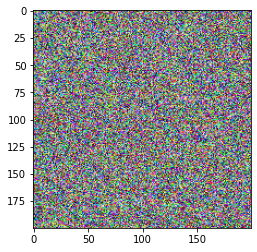

In [536]:
plt.imshow(data_color.reshape(200,200,3));

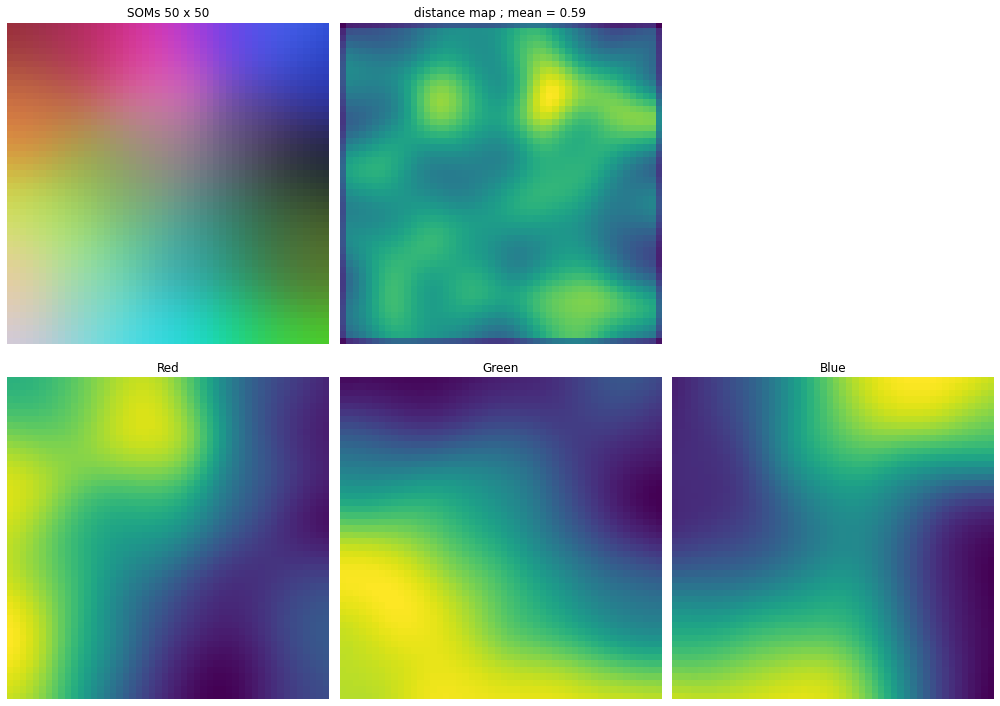

In [568]:
sigma = 10
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

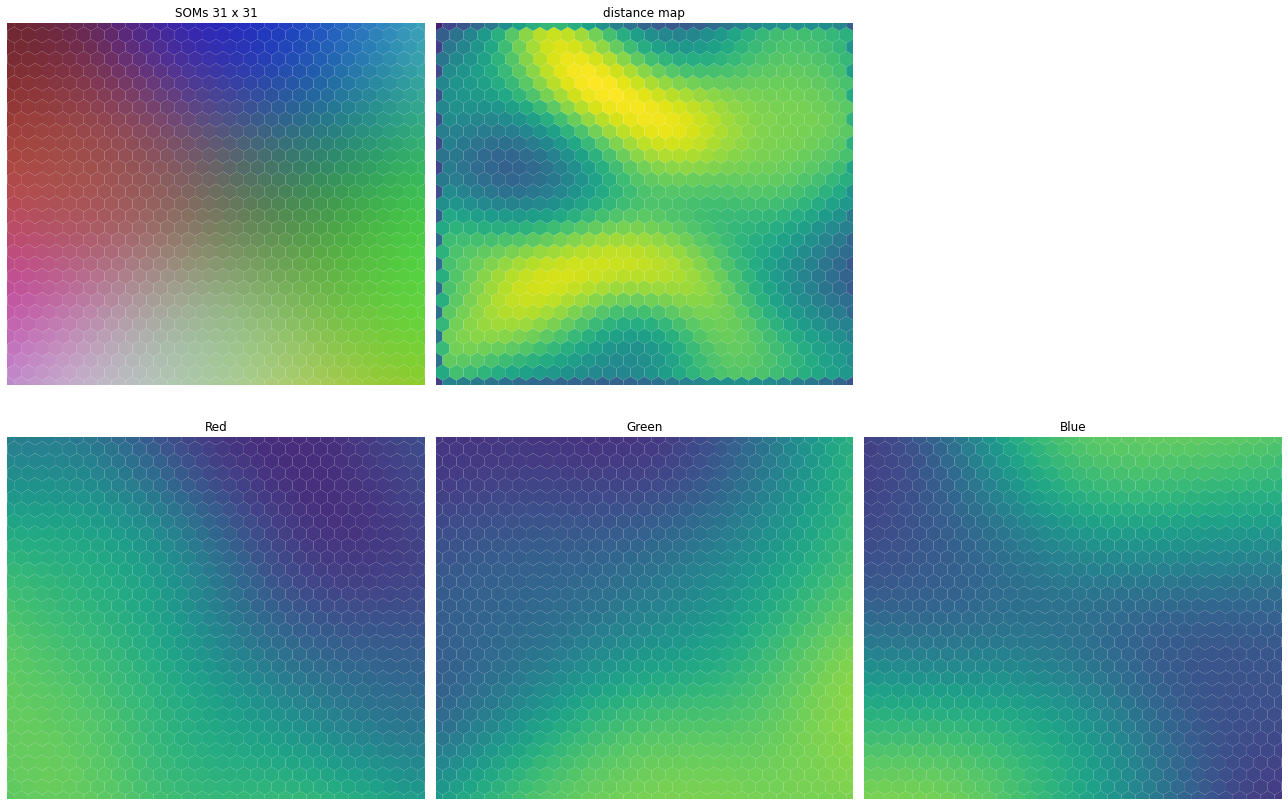

In [539]:
sigma = 10
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000, topology='hexagonal')
som_hexa(data_color, som, weights, color_names)

### Weird result

sigma = 12.0 ; learning rate 1.0 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


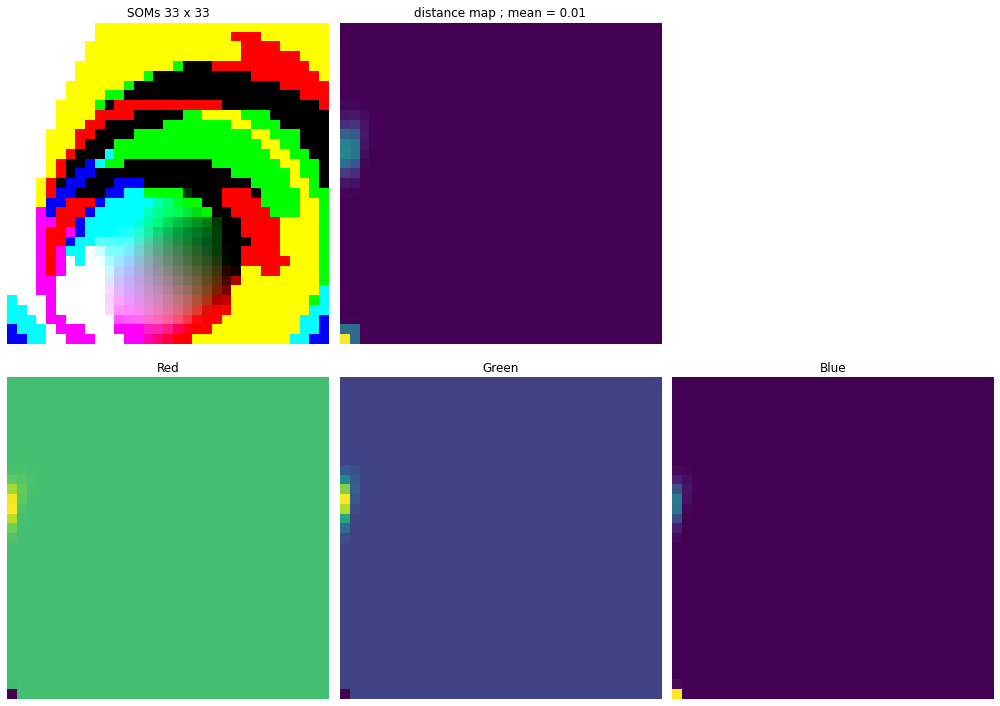

In [ ]:
sigma = 12
learning_rate = 1
print("sigma = %.1f ; learning rate %.1f \n" % (sigma, learning_rate))

som, weights = train_som(data_color, sigma, learning_rate, 1000)

som_color(data_color, som, weights, color_names)
# neighborhood function = bubble 

<a name="S3_4"></a>
## Errors

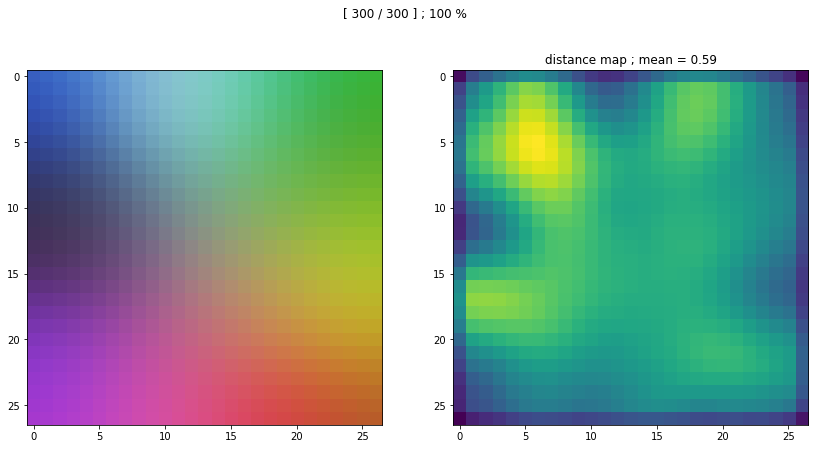

In [545]:
nb, data_color, color_names = dat_color()
X_train, X_test = train_test_split(data_color, test_size=0.05)

sigma = 6
learning_rate = 0.2
iterations = 300
frequence = 5

som, weights, iter_x, q_error, q_error_val, t_error, mapmean = train_and_get_error(X_train, X_test, 
                                    sigma, learning_rate, 
                                    iterations, frequence, 
                                    topological_error=False, get_res=True)

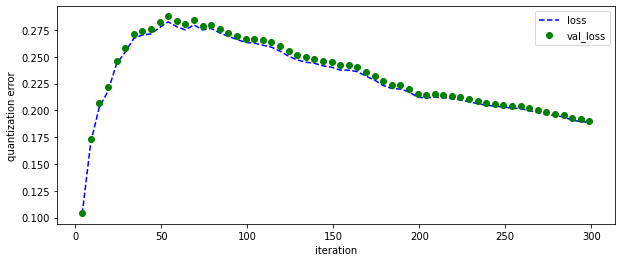

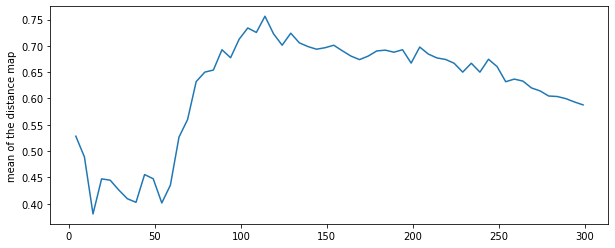

In [546]:
plot_error(iter_x, q_error, q_error_val, t_error, mapmean)

<a name="S3_2"></a>
## Interactive SOMs

### Rectangular

In [569]:
nb, data_color, color_names = dat_color()

In [575]:
interactive_plot(data_color, nb, color_names)

interactive(children=(FloatSlider(value=7.0, description='sigma', layout=Layout(height='40px', width='40%'), m…

### Hexagonal

In [549]:
nb, data_color, color_names = dat_color()

In [550]:
interactive_plot(data_color, nb, color_names, topology='hexagonal')

interactive(children=(FloatSlider(value=7.0, description='sigma', layout=Layout(height='40px', width='40%'), m…

## SOMperf

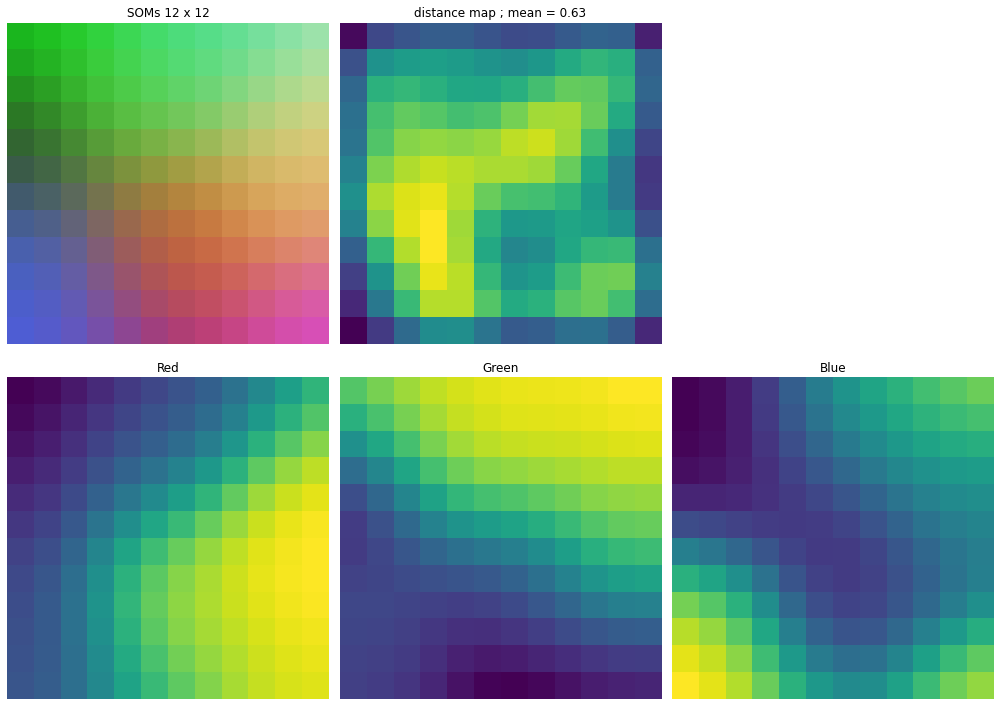

In [580]:
nb, data_color, color_names = dat_color(nb=1000)

sigma = 4
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 1000)
som_color(data_color, som, weights, color_names)

In [581]:
w_r = weights.reshape(weights.shape[0]*weights.shape[1], -1)

In [582]:
print("quantization error %.3f ; topographic error %.3f" %(
    som.quantization_error(data_color),
    som.topographic_error(data_color)))

quantization error 0.201 ; topographic error 0.015


In [583]:
print("neighborhood preservation %.3f ; trustworthiness %.3f" %(
    neighborhood_preservation_trustworthiness(1, w_r, data_color)))

neighborhood preservation 0.724 ; trustworthiness 0.956


## Heatmap, visible edges conditions

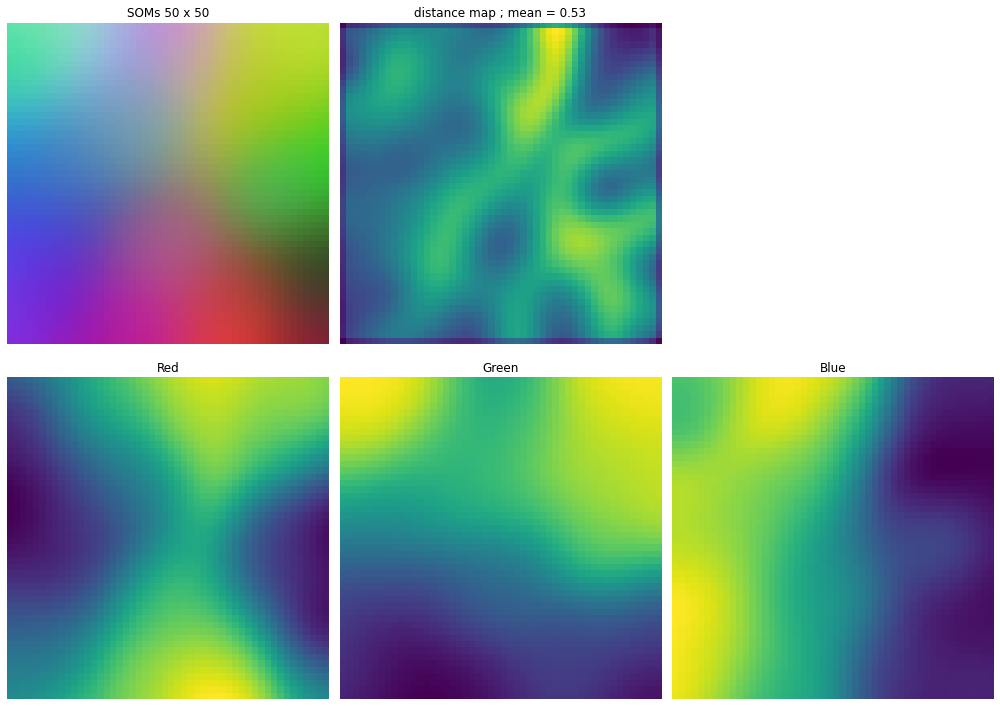

In [559]:
nb, data_color, color_names = dat_color(nb=250000)

sigma = 9
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 100)
som_color(data_color, som, weights, color_names)

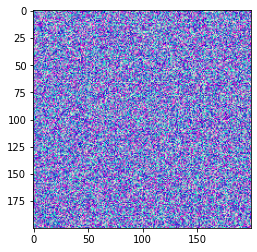

In [560]:
NB = 40000
a = np.random.uniform(0,1,NB)
b = np.random.uniform(0,1,NB)
c = np.random.normal(.8,.05,NB)

c /= max(c)

abc = np.vstack([a,b,c]).T

plt.imshow(abc.reshape(200,200,3));

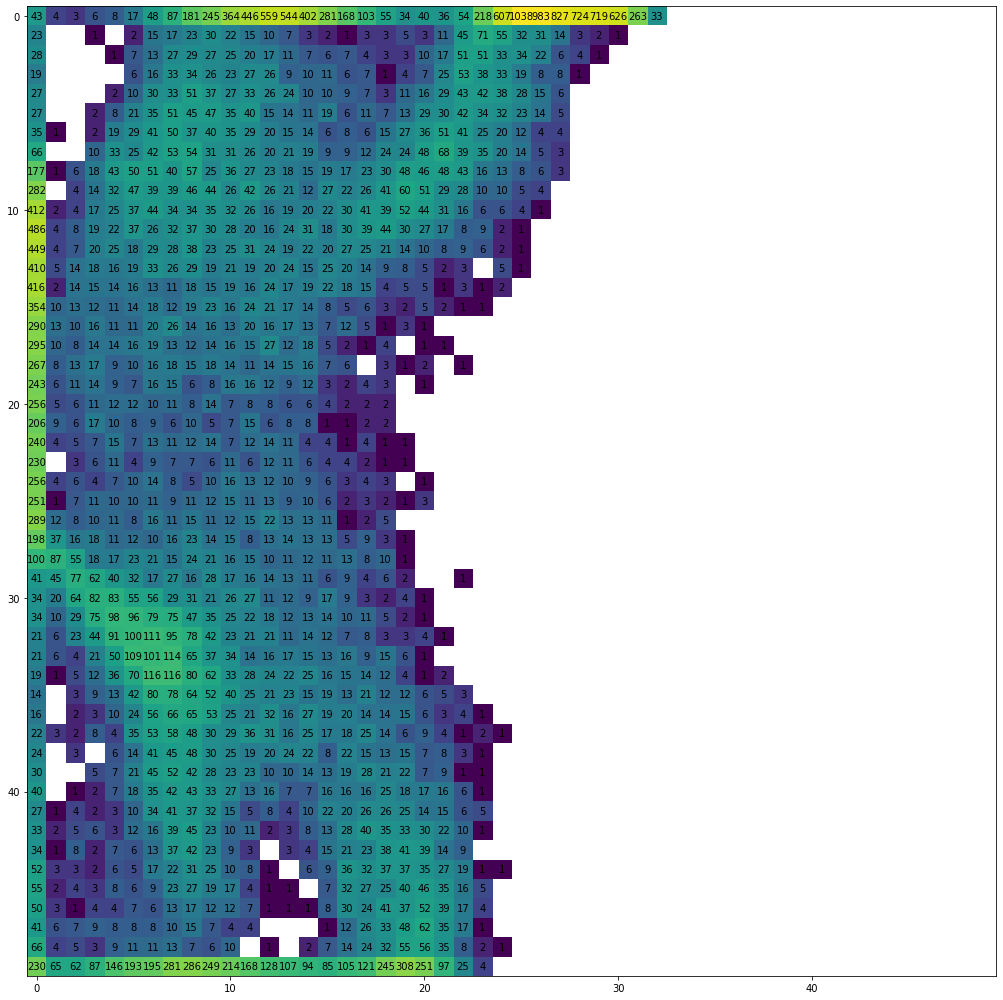

In [561]:
Heatmap(som, abc) # abc -> dataset fortement bleu -> hitmap tres proche de blue_weights

### Coord inverted example

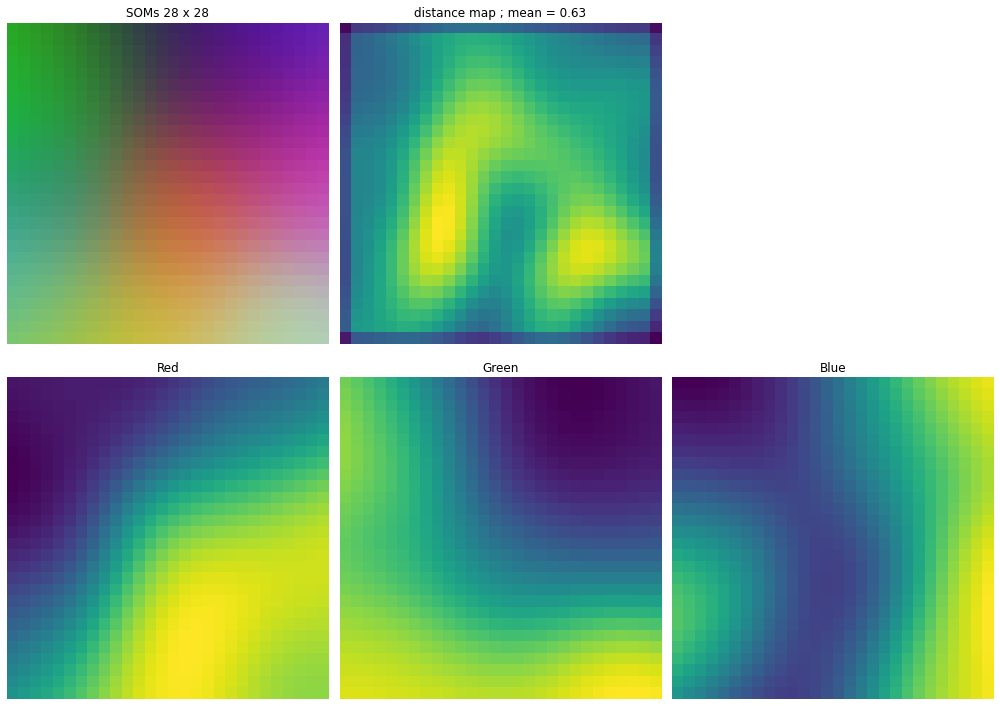

In [ ]:
nb, data_color, color_names = dat_color()

sigma = 9
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 1000)
som_color(data_color, som, weights, color_names)

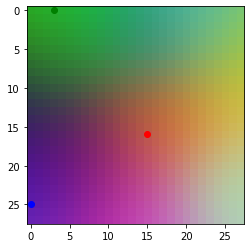

In [ ]:
w3 = weights.copy()
for i in range(3):
    w3[:,:,i]=w3[:,:,i].T

plt.imshow(w3)

r,g,b = [[1,0,0], [0,1,0], [0,0,1]]

plt.scatter(*som.winner(r), color='red')
plt.scatter(*som.winner(g), color='green')
plt.scatter(*som.winner(b), color='blue');

In [ ]:
som.winner(g)

(3, 0)

(array([3]), array([0]))


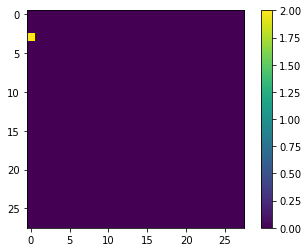

In [ ]:
print(np.where(som.activation_response([g,g])))

plt.imshow(som.activation_response([g,g]))
plt.colorbar();

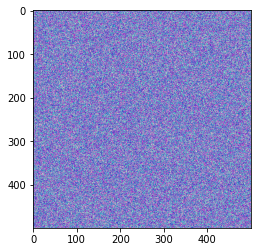

In [ ]:
NB = 250000
a = np.random.uniform(0,1,NB)
b = np.random.uniform(0,1,NB)
c = np.random.normal(.8,.05,NB)
c /= max(c)

abc = np.vstack([a,b,c]).T

plt.imshow(abc.reshape(500,500,3));

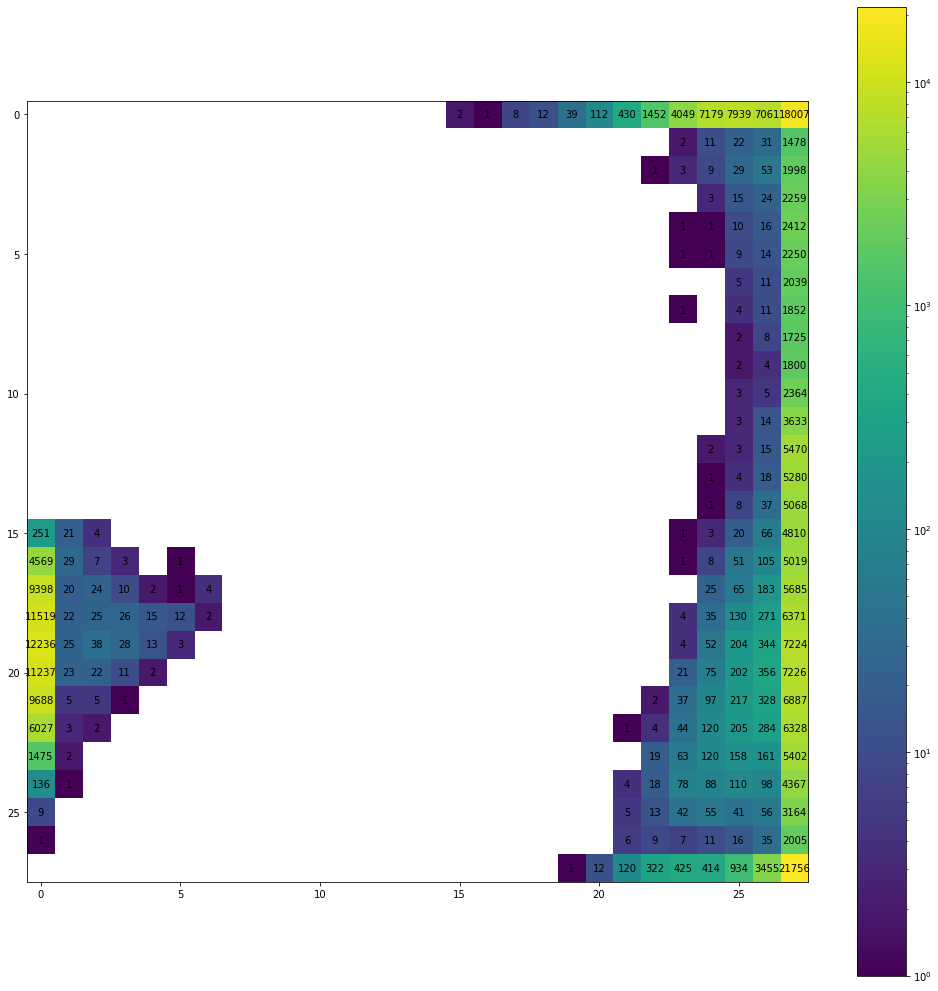

In [ ]:
Hitmap(som, abc) # abc -> dataset fortement bleu -> hitmap tres proche de blue_weights

## Tests heatmap, uniform normalized dataset

### RGB A

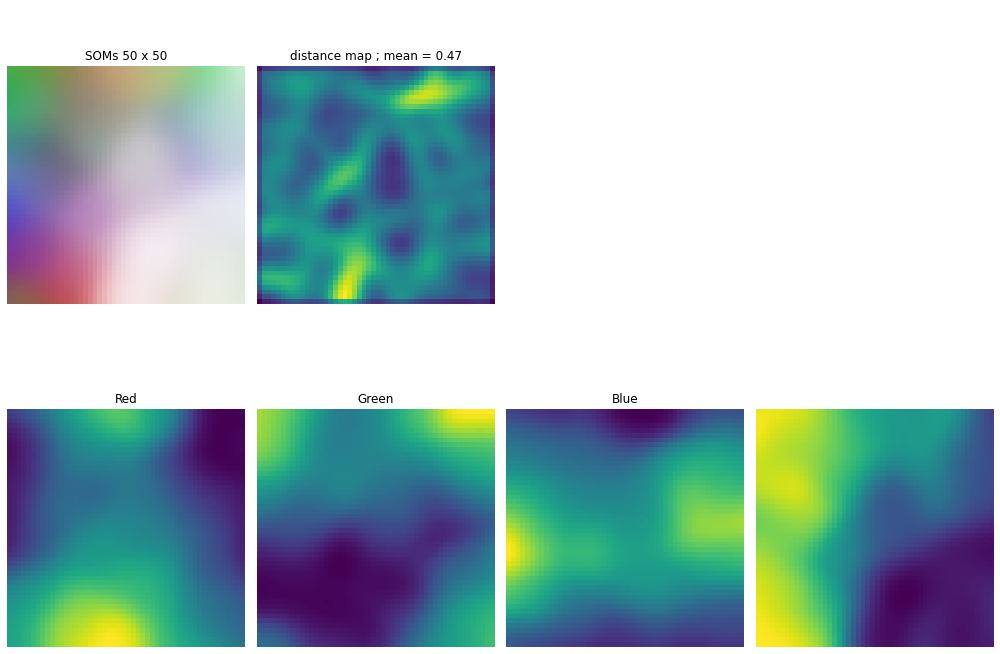

In [432]:
nb=250000
dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,dat2,dat3)).T


# normalize each row
sum_of_rows = data_color.sum(axis=1)
data_color_norm = data_color / sum_of_rows[:, np.newaxis]


# adding 4th column for the intensity
dat4 = np.random.uniform(0,1,nb)
#dat4 = np.random.normal(.5, .1, nb)
data_color = np.vstack((data_color_norm.T, dat4)).T


# SOMs
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

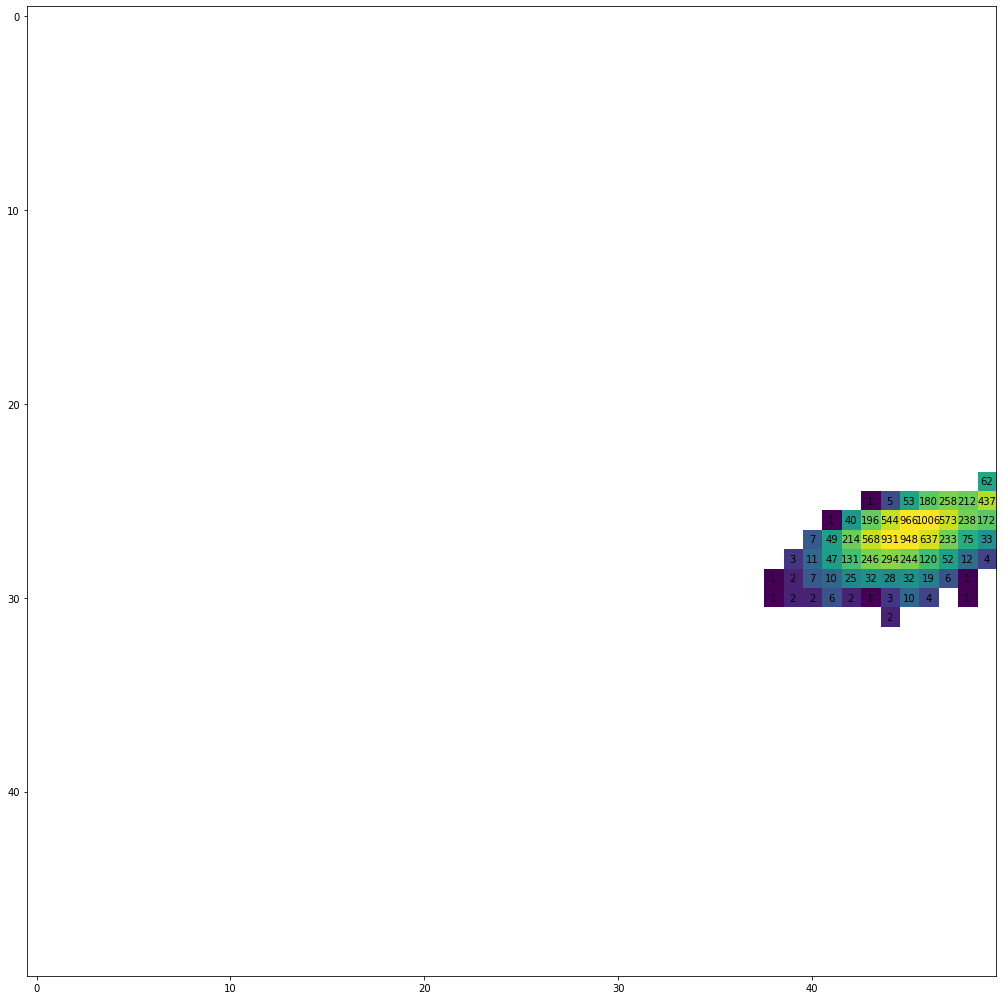

In [434]:
NB = 10000

a = np.random.normal(.2,.05,NB) # red
b = np.random.normal(.2,.05,NB) # green
c = np.random.normal(.7,.05,NB) # blue ----

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc_norm = abc / sum_of_rows[:, np.newaxis]

# adding 4th column for the intensity
dat4 = np.random.uniform(0,.1,NB)
abc = np.vstack((abc_norm.T, dat4)).T


Heatmap(som, abc)

### RGB

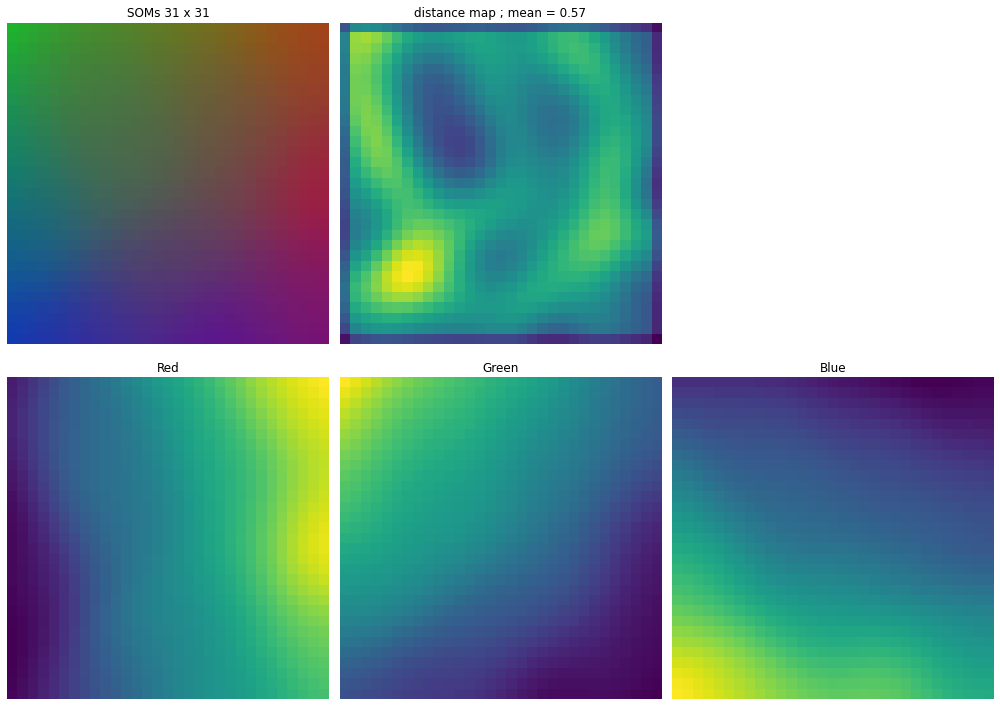

In [509]:
nb = 40000 ; nb_reshape = int(np.sqrt(nb))

dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,dat2,dat3)).T


# normalize each row
sum_of_rows = data_color.sum(axis=1)
data_color = data_color / sum_of_rows[:, np.newaxis]


# SOMs
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

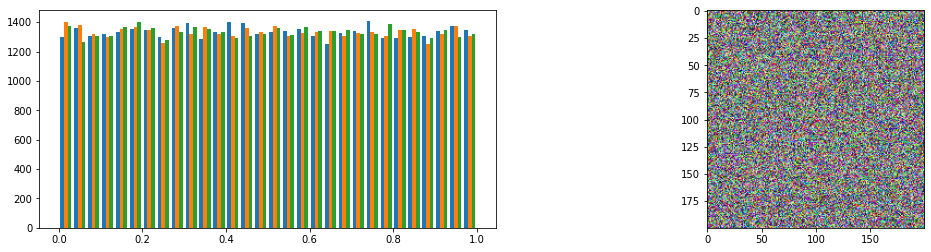

In [511]:
# before normalization
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.hist(np.vstack((dat1,dat2,dat3)).T, bins=30)
plt.subplot(122)
plt.imshow(np.vstack((dat1,dat2,dat3)).T.reshape(nb_reshape,nb_reshape,3))
plt.show()

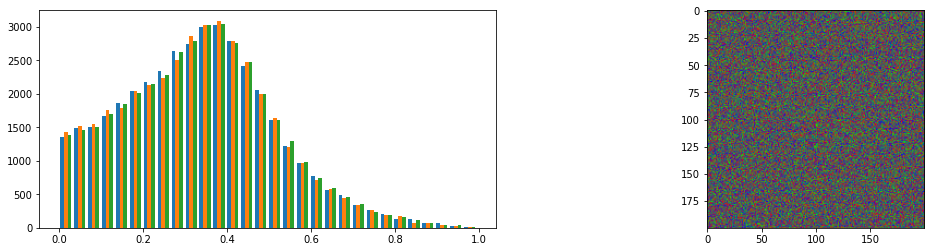

In [512]:
# after normalization
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.hist(data_color, bins=30)
plt.subplot(122)
plt.imshow(data_color.reshape(nb_reshape,nb_reshape,3))
plt.show()

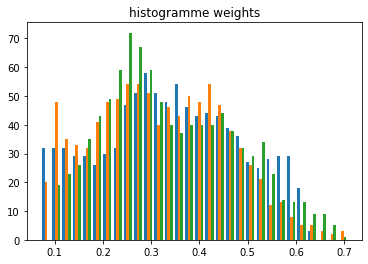

In [513]:
plt.title("histogramme weights")
plt.hist(weights.reshape( np.prod(weights.shape[0:2]) , 3), bins=30 );

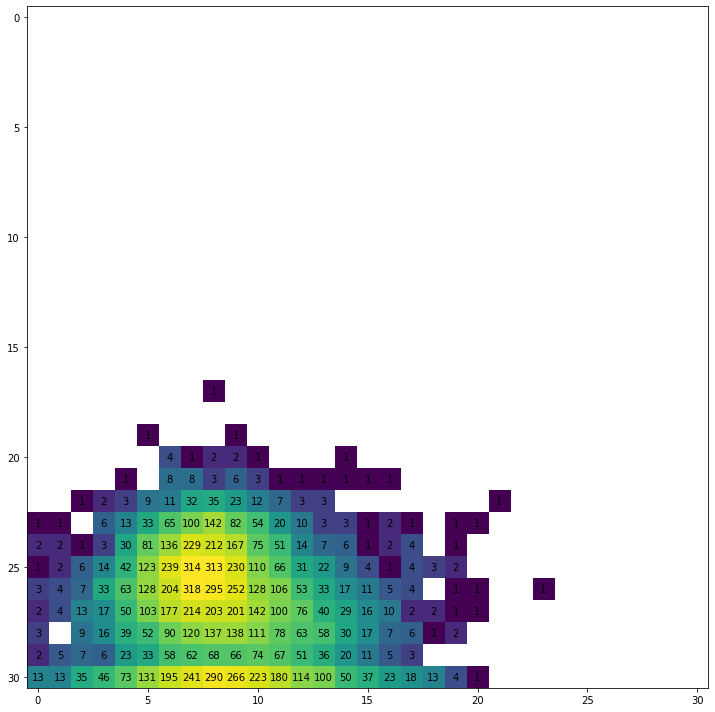

In [517]:
NB = 10000

a = np.random.normal(.2,.05,NB)
b = np.random.normal(.2,.05,NB)
c = np.random.normal(.5,.05,NB)

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc = abc / sum_of_rows[:, np.newaxis]

Heatmap(som, abc, figsize=(10,10))

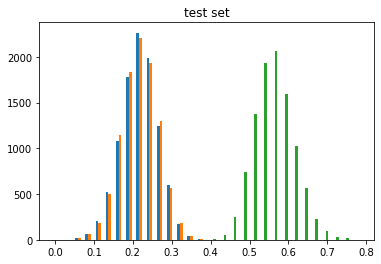

In [518]:
plt.title("test set")
plt.hist(abc,bins=30); # blue at the right

#### Other normalizations

In [519]:
nb_test=250000

coord=[]
for i in range(nb_test):
    theta = np.random.uniform(np.pi)
    phi = np.random.uniform(np.pi*2)  

    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    coord.append([x,y,z])

coord = np.abs(coord)

In [520]:
coord # normalisé sqrt(x^2+...)=1 -> pas bon

array([[0.35544628, 0.0413049 , 0.93378362],
       [0.7568681 , 0.25181632, 0.60310797],
       [0.74158914, 0.199099  , 0.6406287 ],
       ...,
       [0.84668365, 0.44259984, 0.29535094],
       [0.20960774, 0.16586856, 0.96361414],
       [0.51534796, 0.84871443, 0.11874468]])

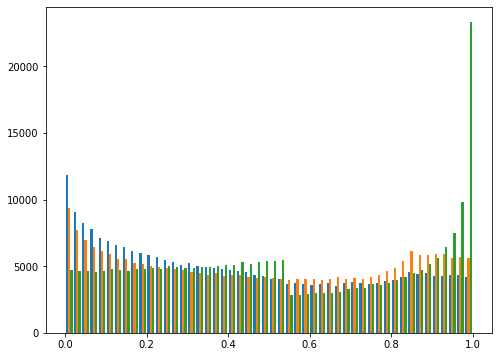

In [521]:
plt.figure(figsize=(8,6))
plt.hist(coord, bins=50);

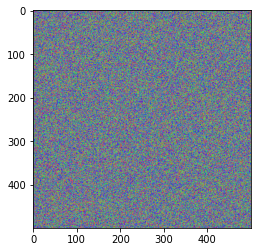

In [522]:
plt.imshow(coord.reshape(500,500,3));

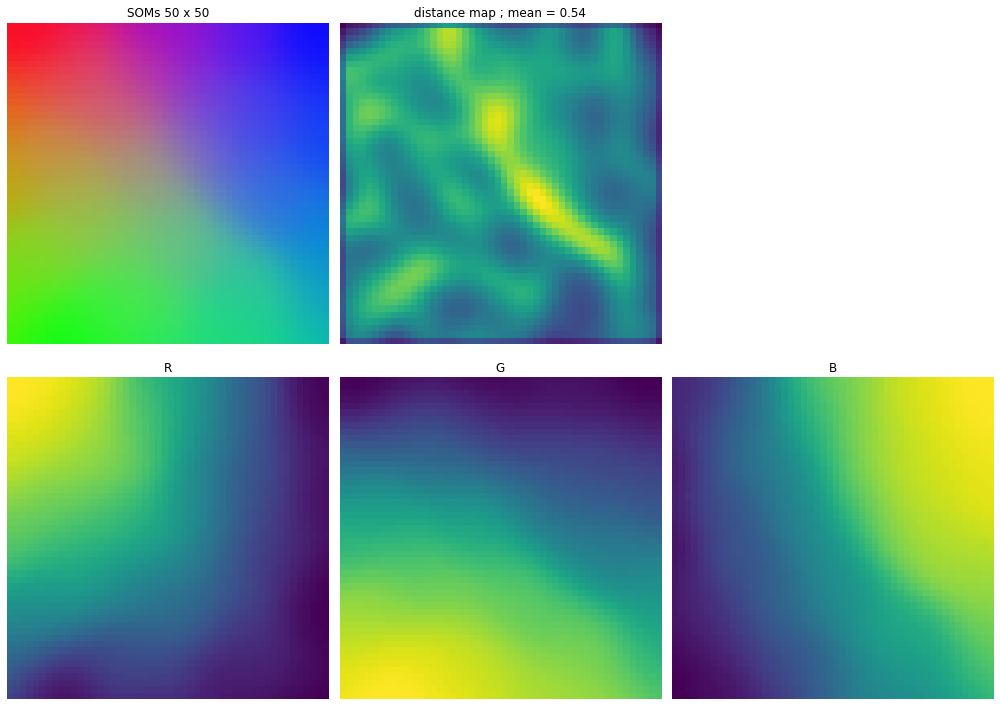

In [523]:
# SOMs
sigma = 7
learning_rate = 1

som_coord, weights_coord = train_som(coord, sigma, learning_rate, 5000)
som_color(coord, som_coord, weights_coord)

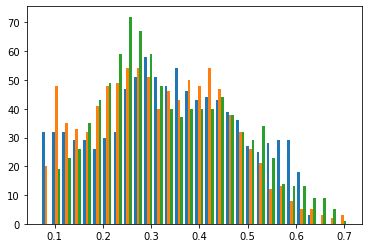

In [528]:
plt.hist(weights.reshape( np.prod(weights.shape[0:2]) , 3),bins=30);

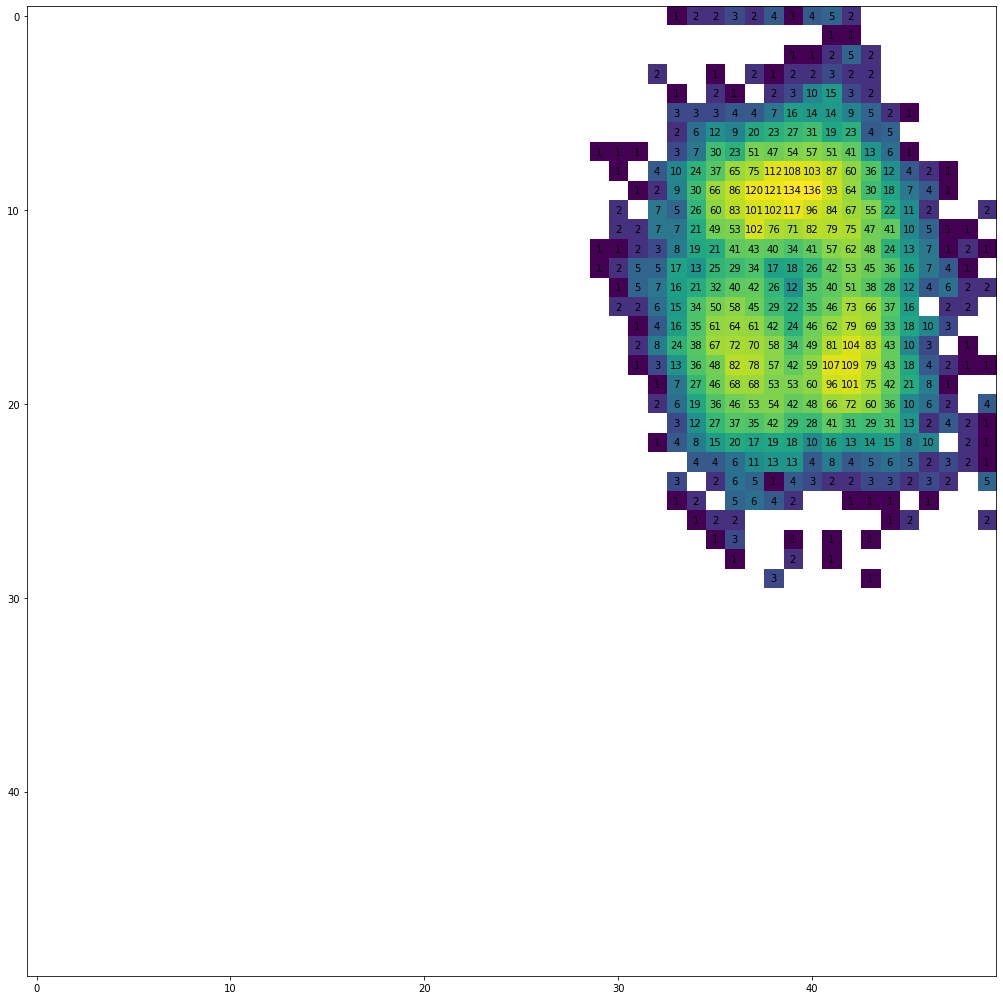

In [526]:
NB = 10000

a = np.random.normal(.2,.05,NB) # red
b = np.random.normal(.2,.05,NB) # green
c = np.random.normal(.7,.05,NB) # blue ----

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc = abc / sum_of_rows[:, np.newaxis]

Heatmap(som_coord, abc)

## GHSOM

In [20]:
nb, data_color, color_names = dat_color()

som = GHSOM(data_color, t1=0.3, t2=0.002, learning_rate=0.15, decay=0.9, gaussian_sigma=1.2)
ghsom = som.train()

print(ghsom)

[Elapsed Time: 0:00:42] |######################################| (25000/25000) 

position (0, 0) -- map dimensions (1, 1, 3) -- input dataset 25000 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 5785 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 1572 element(s) -- level 2 
			position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 442 element(s) -- level 3 
				position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 101 element(s) -- level 4 
				position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 115 element(s) -- level 4 
				position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 118 element(s) -- level 4 
				position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 108 element(s) -- level 4 
			position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 393 element(s) -- level 3 
				position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 96 element(s) -- level 4 
				position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 99 element(s) -- level 

In [21]:
gmap = ghsom.child_map

In [ ]:
"""
def repr(gmap, level):
    gap = '\t'*level
    _printable = "{}level {} \n".format(
        gap,
        level
    )

    if (level==2):
        return _printable

    if gmap.child_map is not None:

        for neuron in gmap.child_map.neurons:
            print("------ lvl %d ------"%level)
            print(neuron)
            print(gmap.child_map.weights_map)

            _printable += repr(gmap, level+1)
            break
    return _printable
"""

In [332]:
def repr(gmap, weights, level):

    if (level==3
        #gmap.child_map is None
        ):
        return weights

    if gmap.child_map is not None:

        for neuron in gmap.child_map.neurons:
            print("\n------ lvl %d ------"%level)
            print("neuron", neuron)
            print(gmap.child_map.weights_map)
            
            weights.append(gmap.child_map.weights_map[0][neuron])
            print("weights",weights)
            
            weights.append( repr(gmap, weights, level+1) )
            gmap = gmap.child_map.neurons
            break
    return weights

In [321]:
type(ghsom)

neuron.neuron.Neuron

In [328]:
type(ghsom.child_map.neurons)

dict

In [333]:
weights = repr(ghsom, [], 0)


------ lvl 0 ------
neuron (0, 0)
[array([[[0.73384183, 0.30032126, 0.70846432],
        [0.31541928, 0.23491573, 0.38106502]],

       [[0.43345378, 0.736815  , 0.74613088],
        [0.56223111, 0.74640985, 0.22592993]]])]
weights [array([0.73384183, 0.30032126, 0.70846432])]

------ lvl 1 ------
neuron (0, 0)
[array([[[0.73384183, 0.30032126, 0.70846432],
        [0.31541928, 0.23491573, 0.38106502]],

       [[0.43345378, 0.736815  , 0.74613088],
        [0.56223111, 0.74640985, 0.22592993]]])]
weights [array([0.73384183, 0.30032126, 0.70846432]), array([0.73384183, 0.30032126, 0.70846432])]

------ lvl 2 ------
neuron (0, 0)
[array([[[0.73384183, 0.30032126, 0.70846432],
        [0.31541928, 0.23491573, 0.38106502]],

       [[0.43345378, 0.736815  , 0.74613088],
        [0.56223111, 0.74640985, 0.22592993]]])]
weights [array([0.73384183, 0.30032126, 0.70846432]), array([0.73384183, 0.30032126, 0.70846432]), array([0.73384183, 0.30032126, 0.70846432])]


### gmap

In [257]:
pos0_0 = gmap.neurons[0,0]

In [258]:
neurrr = gmap.neurons

In [27]:
pos0_0_0 = pos0_0.child_map.neurons[0,0]
pos0_0_0

position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 1220 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 268 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 71 element(s) -- level 2 
		position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 72 element(s) -- level 2 
		position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 60 element(s) -- level 2 
		position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 65 element(s) -- level 2 
	position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 299 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 91 element(s) -- level 2 
		position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 68 element(s) -- level 2 
		position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 67 element(s) -- level 2 
		position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 73 element(s) -- level 2 
	position (1, 0) -- m

In [28]:
pos0_0_0_0 = pos0_0_0.child_map.neurons[0,0]
pos0_0_0_0

position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 268 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 71 element(s) -- level 1 
	position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 72 element(s) -- level 1 
	position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 60 element(s) -- level 1 
	position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 65 element(s) -- level 1 

In [29]:
pos0_0_0_0_all = pos0_0_0_0.child_map
pos0_0_0_0_all.weights_map

[array([[[0.41207718, 0.5767142 , 0.55124066],
         [0.28912619, 0.61535766, 0.5637153 ]],
 
        [[0.44100227, 0.57605806, 0.62626278],
         [0.30449188, 0.61564421, 0.68280996]]])]

In [30]:
pos0_0_0_0_0 = pos0_0_0_0.child_map.neurons[0,0]
pos0_0_0_0_0

position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 71 element(s) -- level 0 

In [81]:
pos0_0_0_0_0._Neuron__weight_map[0]

array([[[0.41207718, 0.5767142 , 0.55124066],
        [0.28912619, 0.61535766, 0.5637153 ]],

       [[0.44100227, 0.57605806, 0.62626278],
        [0.30449188, 0.61564421, 0.68280996]]])

In [246]:
for i in gmap.neurons.keys():
    print(i)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


### tab weights

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
fig = plt.figure(figsize=(8,8))
outer = gridspec.GridSpec(2, 2, wspace=0., hspace=0.)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outer[i], wspace=0., hspace=0.)

    for j in range(4):
        ax = plt.Subplot(fig, inner[j])
        t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
        t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()

In [140]:
lvl_0 = np.zeros((2,2),dtype=object)
tab_weights = []

idx1=-1
for i in gmap.neurons.keys():
    lvl_0[i] = gmap.neurons[i]
    gmap_1 = lvl_0[i].child_map
    idx1+=1

    idx2=-1
    for m in np.concatenate(gmap_1.weights_map[0]):
        idx2+=1
        tab_weights.append([idx1,idx2,m])

tab_weights = np.array(tab_weights)
print(tab_weights.shape)
tab_weights

(16, 3)


array([[0, 0, array([0.52571697, 0.20877727, 0.79427922])],
       [0, 1, array([0.85121238, 0.18986697, 0.8331853 ])],
       [0, 2, array([0.82107975, 0.51109716, 0.70590665])],
       [0, 3, array([0.85604511, 0.19571159, 0.3502901 ])],
       [1, 0, array([0.43259709, 0.20578476, 0.42021136])],
       [1, 1, array([0.54106589, 0.19611846, 0.12573268])],
       [1, 2, array([0.15090118, 0.18873863, 0.6730285 ])],
       [1, 3, array([0.15923283, 0.35587744, 0.26135234])],
       [2, 0, array([0.48254309, 0.76068745, 0.72818485])],
       [2, 1, array([0.24749082, 0.53874479, 0.84727972])],
       [2, 2, array([0.81493589, 0.86634655, 0.81620095])],
       [2, 3, array([0.12434541, 0.81241713, 0.66136908])],
       [3, 0, array([0.5308    , 0.72755129, 0.24840269])],
       [3, 1, array([0.84154898, 0.80324239, 0.29096683])],
       [3, 2, array([0.19534749, 0.7846272 , 0.17617142])],
       [3, 3, array([0.78067388, 0.51192669, 0.14921713])]], dtype=object)

In [178]:
tab16_3 = np.array(tab_weights[:,-1].tolist())
tab16_2x = tab16_3.reshape(4,2,2,3)

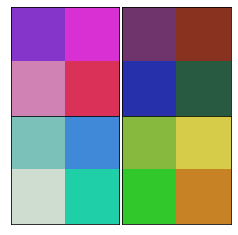

In [184]:
fig = plt.figure(figsize=(4,4))
outer = gridspec.GridSpec(2, 2, wspace=0., hspace=0.)

for j in range(4):
    ax = plt.Subplot(fig, outer[j])

    ax.imshow(tab16_2x[j])

    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

fig.show()

In [26]:
lvl_0 = np.zeros((2,2),dtype=object)
lvl_1 = np.zeros((2,2),dtype=object)
lvl_2 = np.zeros((2,2),dtype=object)
tab_weights = []

idx1=-1
for i in gmap.neurons.keys():
    lvl_0[i] = gmap.neurons[i]
    gmap_1 = lvl_0[i].child_map
    idx1+=1

    idx2=-1
    for j in gmap_1.neurons.keys():
        lvl_1[j] = gmap_1.neurons[j]
        gmap_2 = lvl_1[j].child_map
        idx2+=1

        idx3=-1
        for k in gmap_2.neurons.keys():
            lvl_2[k] = gmap_2.neurons[k]
            
            if lvl_2[k].child_map is not None:
                gmap_3 = lvl_2[k].child_map
            else:
                gmap_3 = lvl_2[k]
            idx3+=1

            idx4=-1
            try:
                for l in np.concatenate(gmap_3.weights_map[0]):
                    idx4+=1
                    tab_weights.append([idx1,idx2,idx3,idx4,l])
            except:
                for l in np.concatenate(gmap_3._Neuron__weight_map[0]):
                    idx4+=1
                    tab_weights.append([idx1,idx2,idx3,idx4,l])

tab_weights = np.array(tab_weights)
print(tab_weights.shape)
tab_weights

(256, 5)


array([[0, 0, 0, 0, array([0.40001374, 0.20671726, 0.83069416])],
       [0, 0, 0, 1, array([0.33322367, 0.23432446, 0.94664094])],
       [0, 0, 0, 2, array([0.49372257, 0.1030418 , 0.94490221])],
       ...,
       [3, 3, 3, 1, array([0.91855109, 0.5320465 , 0.08864762])],
       [3, 3, 3, 2, array([0.83536531, 0.53989307, 0.30887601])],
       [3, 3, 3, 3, array([0.90488153, 0.46577634, 0.20653181])]],
      dtype=object)

In [27]:
tab256_5 = np.array(tab_weights[:,-1].tolist())

tab256_2x = tab256_5.reshape(4,4,4,2,2,3)

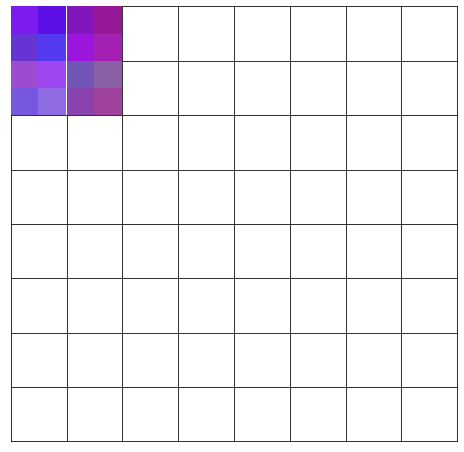

In [70]:
fig = plt.figure(figsize=(8,8))
outer = gridspec.GridSpec(2, 2, wspace=.0, hspace=.0)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outer[i], wspace=.0, hspace=.0)

    for j in range(4):
        if i==0 and j==0:
            ax = plt.Subplot(fig, inner[j])
            inner2 = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=inner[j], wspace=.0, hspace=.0)


            for k in range(4):
                ax1 = plt.Subplot(fig, inner2[k])

                ax1.imshow(tab256_2x[i,j,k],origin="lower")
                ax1.axis('off')

                ax1.set_xticks([]) ; ax1.set_yticks([])
                fig.add_subplot(ax1)
        else:
            ax = plt.Subplot(fig, inner[j])
            inner2 = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=inner[j], wspace=.0, hspace=.0)

            for k in range(4):
                ax1 = plt.Subplot(fig, inner2[k])
                #ax1.imshow(tab256_2x[i,j,k],origin="lower")
                #ax1.axis('off')
                ax1.set_xticks([]) ; ax1.set_yticks([])
                fig.add_subplot(ax1)
plt.show()

In [118]:
tab256_2xT = np.transpose(tab256_2x, (0,2,1,3,4,5)).reshape(4,4,4,2,2,3)

In [127]:
np.transpose(tab256_2x, (0,1,2,4,3,5)).reshape(4,4,4,2,2,3)[0,0]

array([[[[0.40001374, 0.20671726, 0.83069416],
         [0.49372257, 0.1030418 , 0.94490221]],

        [[0.33322367, 0.23432446, 0.94664094],
         [0.36392465, 0.05597361, 0.90159525]]],


       [[[0.60806049, 0.08972033, 0.87000943],
         [0.50261614, 0.08818855, 0.73441612]],

        [[0.64683327, 0.12827871, 0.71313403],
         [0.59536579, 0.09463338, 0.59529699]]],


       [[[0.46806224, 0.34438305, 0.86768883],
         [0.6177905 , 0.29573308, 0.81905665]],

        [[0.56305641, 0.42279438, 0.8974439 ],
         [0.62480017, 0.2835048 , 0.94749121]]],


       [[[0.53853565, 0.25962637, 0.68609191],
         [0.44822803, 0.3360841 , 0.7143971 ]],

        [[0.62855281, 0.25944312, 0.61711839],
         [0.54078101, 0.37717423, 0.64412695]]]])

In [101]:
tab256_2x[0,0]

array([[[[0.40001374, 0.20671726, 0.83069416],
         [0.33322367, 0.23432446, 0.94664094]],

        [[0.49372257, 0.1030418 , 0.94490221],
         [0.36392465, 0.05597361, 0.90159525]]],


       [[[0.60806049, 0.08972033, 0.87000943],
         [0.64683327, 0.12827871, 0.71313403]],

        [[0.50261614, 0.08818855, 0.73441612],
         [0.59536579, 0.09463338, 0.59529699]]],


       [[[0.46806224, 0.34438305, 0.86768883],
         [0.56305641, 0.42279438, 0.8974439 ]],

        [[0.6177905 , 0.29573308, 0.81905665],
         [0.62480017, 0.2835048 , 0.94749121]]],


       [[[0.53853565, 0.25962637, 0.68609191],
         [0.62855281, 0.25944312, 0.61711839]],

        [[0.44822803, 0.3360841 , 0.7143971 ],
         [0.54078101, 0.37717423, 0.64412695]]]])

In [98]:
tab256_2x.shape

(4, 4, 4, 2, 2, 3)

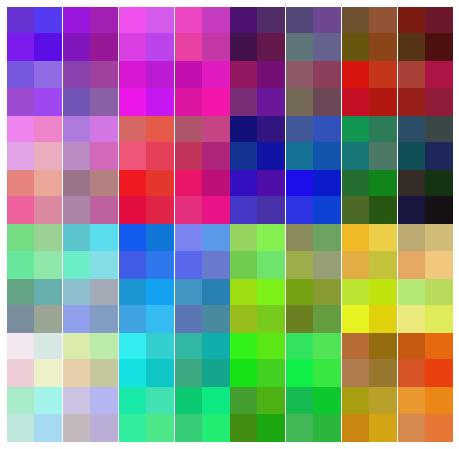

In [125]:
fig = plt.figure(figsize=(8,8))
outer = gridspec.GridSpec(2, 2, wspace=.0, hspace=.0)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outer[i], wspace=.0, hspace=.0)

    for j in range(4):
        ax = plt.Subplot(fig, inner[j])
        inner2 = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=inner[j], wspace=.0, hspace=.0)

        for k in range(4):
            ax1 = plt.Subplot(fig, inner2[k])

            ax1.imshow(tab256_2x[i,j,k])
            ax1.axis('off')

            ax1.set_xticks([]) ; ax1.set_yticks([])
            fig.add_subplot(ax1)
plt.show()

<a name="S3_3"></a>
## Test hyperparams auto

In [ ]:
# finding the 2 parameters at the same time

rows = data_color.shape[0]
som_x = int(np.sqrt(5*np.sqrt(rows)))
som_y = som_x

space = {'sig' : hp.uniform('sig', som_x/10, som_x/2.01),
         'learnR' :hp.uniform('learnR', 0.001, 4)}

def som_fn(space):
    sig = space['sig']
    learnR = space['learnR']

    val = MiniSom(som_x, som_y,
                  data_color.shape[1],
                  sig,
                  learnR,
                  ).quantization_error(data_color)

    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best_params = fmin(
    fn = som_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 10,
    trials = trials
    )

sigma = best_params['sig']
learning_rate = best_params['learnR']

print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

100%|██████████| 10/10 [00:02<00:00,  3.78it/s, best loss: 0.23785618417138957]
sigma = 5.132646 ; learning rate 1.062127 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


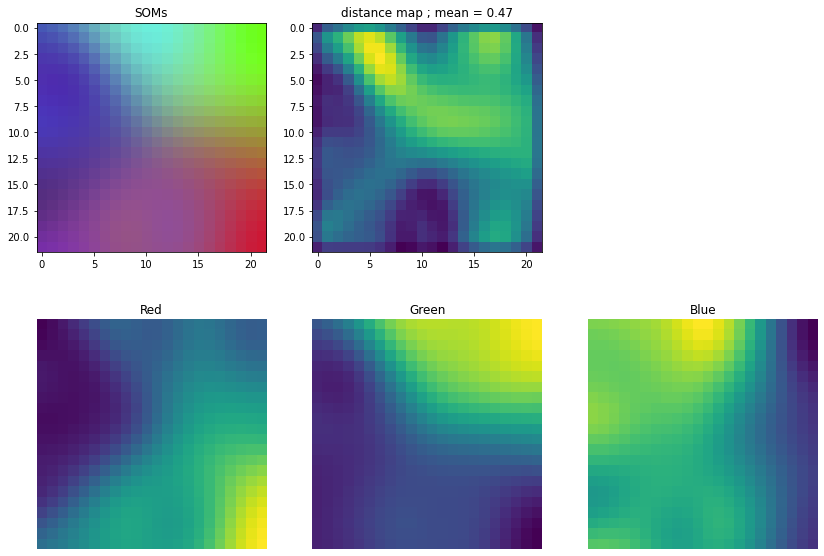

In [ ]:
print("sigma = %.2f ; learning rate %.2f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, sigma, learning_rate, 1000, verbose=False)
som_color(data_color, som, wts_color, color_names) # sigma = 9.263, learning_rate = 3.905

In [ ]:
# finding sigma only
rows = data_color.shape[0]
som_x = int(np.sqrt(5*np.sqrt(rows)))
som_y = som_x

learning_rate = 1

best_sig = fmin(
    fn = lambda sig : MiniSom(som_x,som_y,
                              data_color.shape[1],
                              sig,
                              learning_rate
                              ).quantization_error(data_color),
    space = hp.uniform("sig", som_x/10, som_x/2.01),
    algo = tpe.suggest,
    max_evals=200)

sigma = best_sig["sig"]
print(sigma)

100%|██████████| 200/200 [00:48<00:00,  4.12it/s, best loss: 0.23659006291835552]
8.762504662317241


sigma = 8.76 ; learning rate 1.00 



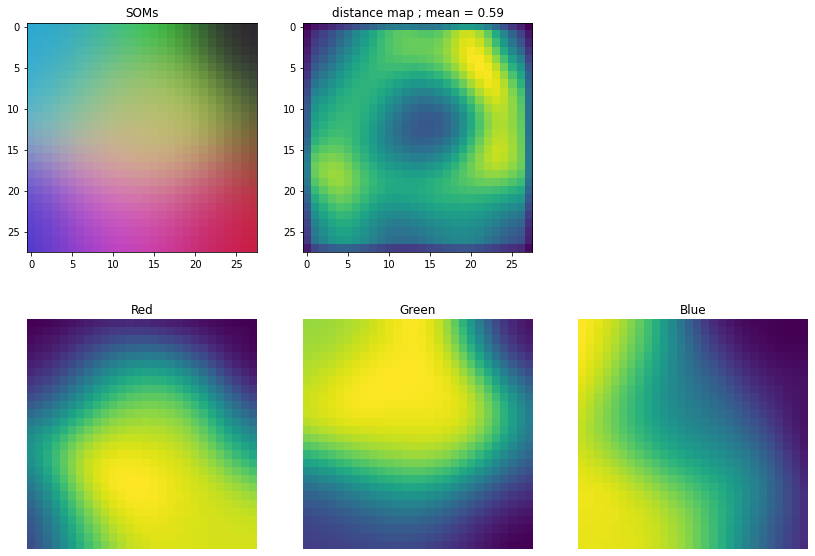

In [ ]:
print("sigma = %.2f ; learning rate %.2f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, sigma, learning_rate, 1000, verbose=False)
som_color(data_color, som, wts_color, color_names)

<a name="S4"></a>
# COSMOS dataset

## Loading datas

In [ ]:
from astropy.io import fits

path_CS_fits = "real_galaxy_catalog_25.2_fits.fits"

with fits.open(path_CS_fits) as hdul:
    hdr = hdul[0].header # header
    data_cs = hdul[1].data # data
    cols = hdul[1].columns # cols 
    Names_cs = cols.names # cols names

### Infos

In [ ]:
hdul.info()
Names_cs

Filename: real_galaxy_catalog_25.2_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   87798R x 14C   [J, D, D, D, 8D, 16D, 5J, D, D, D, J, J, 3D, 4D]   


['IDENT',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux']

In [ ]:
info_min_max(data_cs, Names_cs)

IDENT 

Max 1443979
Min 20

-------------------------------

mag_auto 

Max 1.0
Min 0.704704159505276

-------------------------------

flux_radius 

Max 56.62507247924805
Min 2.796747922897339

-------------------------------

zphot 

Max 0.9777937985249294
Min 0.0009244878030343573

-------------------------------

sersicfit 

Max 181.12170846645134
Min 0.0
---------
Max 0.9998641236334181
Min 0.0
---------
Max 0.9999999997486005
Min 0.016666666915019362
---------
Max 0.999085212018686
Min 0.05
---------
Max 0.0
Min 0.0
---------
Max 475.1418623367244
Min 0.23707499785345132
---------
Max 474.5236215113057
Min 0.0
---------
Max 3.139033454940841
Min -3.1258451514505134
---------

-------------------------------

bulgefit 

Max 203.13294121938745
Min -1.0
---------
Max 2611267.0105977356
Min -1.0
---------
Max 1.0
Min -1.0
---------
Max 2.24520986068672
Min -1.0
---------
Max 0.0
Min -1.0
---------
Max 475.120981973819
Min -1.0
---------
Max 474.4335253681926
Min -1.0
---------
Max 3.

## Making cuts...

### Half light radius cut and conversion :

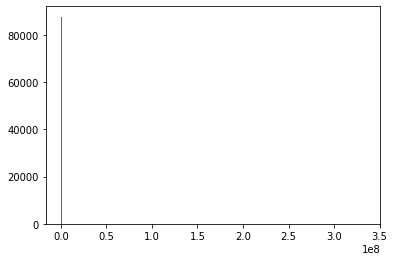

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

In [ ]:
def cut_hight_hlr(cat, lim): # delete hlr problems
    idx = np.where(cat['sersicfit'][:,1]>lim)[0]
    print("nb d'elements suppr", idx.shape)
    cat = np.delete(cat,idx)
    return cat

data_cs['sersicfit'][:,1] *= 0.03 # converting hlr

data_cs = cut_hight_hlr(data_cs, 1.4) # cut hight hlr values on the full catalog

nb d'elements suppr (3171,)


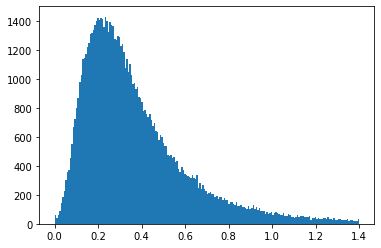

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

In [ ]:
data_cs['sersicfit'][:,1] /= max(data_cs['sersicfit'][:,1])

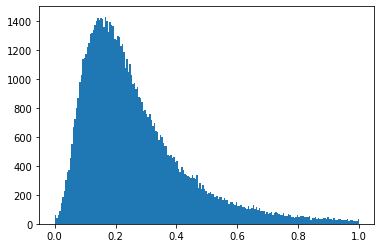

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

### Sersic normalization... and cuts

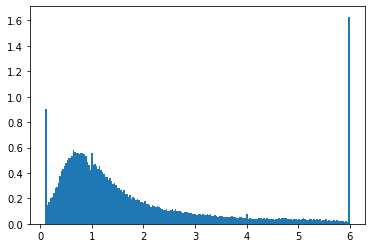

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
np.where(data_cs['sersicfit'][:,2]<0.11)[0].shape

(2063,)

In [ ]:
np.where(data_cs['sersicfit'][:,2]>5.99)[0].shape

(4032,)

In [ ]:
data_cs['sersicfit'][:,2] /= max(data_cs['sersicfit'][:,2]) # normalization

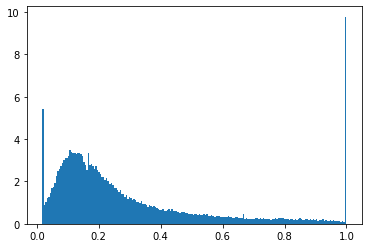

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,2] < 1 )[0] ]

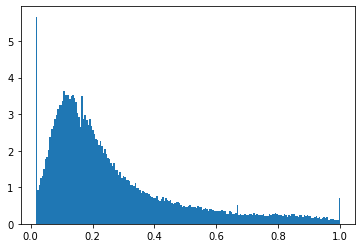

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,2] > min(data_cs['sersicfit'][:,2]) )[0] ]

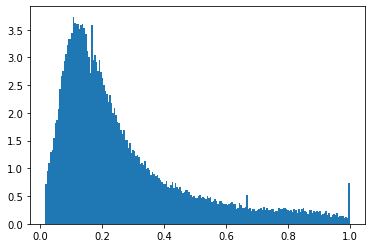

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

### q cut :

In [ ]:
np.where( data_cs['sersicfit'][:,3] > 1 )[0].shape

(14,)

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,3] < 1 )[0] ]

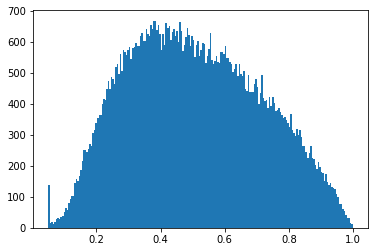

In [ ]:
plt.hist(data_cs['sersicfit'][:,3], bins=200);

In [ ]:
np.where( data_cs['sersicfit'][:,3] < 0.06 )[0].shape

(157,)

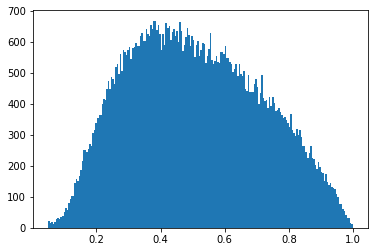

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,3] > 0.05 )[0] ]
plt.hist(data_cs['sersicfit'][:,3], bins=200);

### Intensity at the hlr :

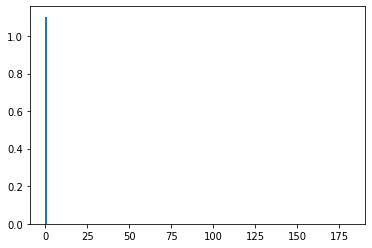

In [ ]:
plt.hist(data_cs['sersicfit'][:,0], bins=200, density=True);

In [ ]:
print(max(data_cs['sersicfit'][:,0]))
print(np.mean(data_cs['sersicfit'][:,0]))
print(min(data_cs['sersicfit'][:,0]))

181.12170846645134
0.07419850816778073
0.0


In [ ]:
np.where( data_cs['sersicfit'][:,0] > 0.3 )[0].shape

(331,)

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,0] < 0.3 )[0] ]

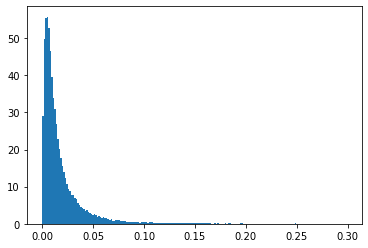

In [ ]:
plt.hist(data_cs['sersicfit'][:,0], bins=200, density=True);

In [ ]:
print(max(data_cs['sersicfit'][:,0]))
print(np.mean(data_cs['sersicfit'][:,0]))
print(min(data_cs['sersicfit'][:,0]))

0.29857793358805385
0.018726944985234334
0.0


### Magnitude

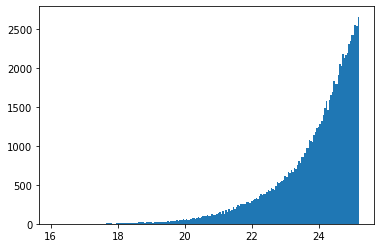

In [ ]:
plt.hist(data_cs['mag_auto'], bins=200);

In [ ]:
max(data_cs['mag_auto'])

25.19999122619629

In [ ]:
# magnitude
data_cs['mag_auto'] /= max(data_cs['mag_auto'])

# photometric redshift
#data_cs['zphot'] /= max(data_cs['zphot'])

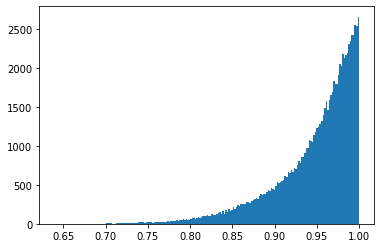

In [ ]:
plt.hist(data_cs['mag_auto'], bins=200);

## Selecting variables

In [ ]:
variables = ['magnitude', 
             'intensity at the hlr',
             'half_light_radius', 
             'Sersic',
             'q', 
             'photometric redshift',
             ]

caption = Label(value='Select some variables (at least 2)')
boxs = [Checkbox(description=i) for i in variables]

display(caption, *boxs)

Label(value='Select some variables (at least 2)')

Checkbox(value=False, description='magnitude')

Checkbox(value=False, description='intensity at the hlr')

Checkbox(value=False, description='half_light_radius')

Checkbox(value=False, description='Sersic')

Checkbox(value=False, description='q')

Checkbox(value=False, description='photometric redshift')

In [ ]:
Datas = [data_cs['mag_auto'],
         data_cs['sersicfit'][:,0],
         data_cs['sersicfit'][:,1],
         data_cs['sersicfit'][:,2],
         data_cs['sersicfit'][:,3],
         data_cs['zphot'],
         ]

dataset_i = []
vars_cs = []
cols = 0
for i in range(len(boxs)):
    if boxs[i].value==1:
        dataset_i.append(Datas[i])
        vars_cs.append(variables[i])
        cols += 1

assert cols>1, "pick at least 2 variables"

choice_cs = np.vstack([*dataset_i]).T


nb_cs = data_cs.shape[0] # rows number 
print("Nombre d'éléments :", nb_cs)
print("Selected variables :",vars_cs)

Nombre d'éléments : 87798
Selected variables : ['intensity at the hlr', 'Sersic']


## SOMs training and visualisation

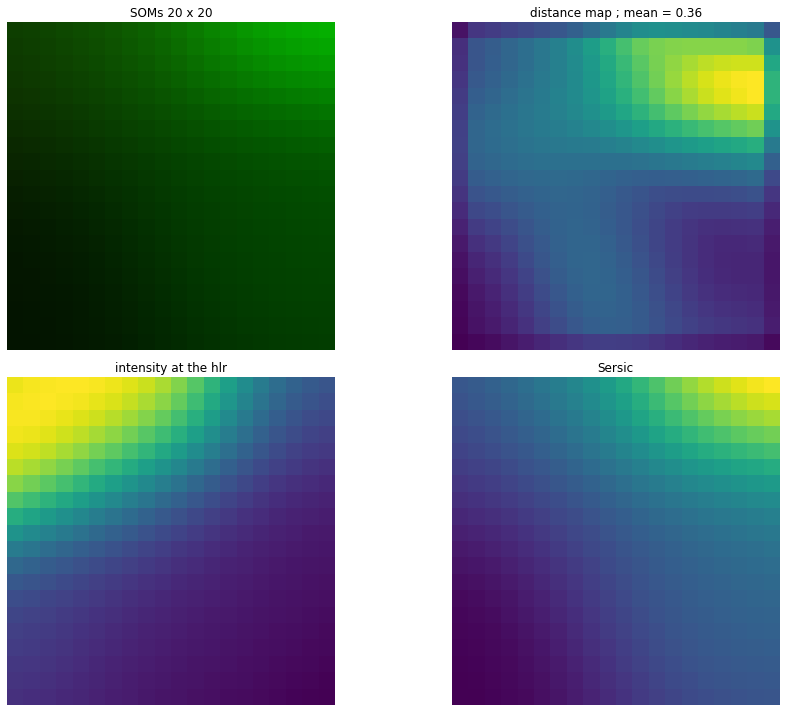

In [ ]:
sigma = 9
learning_rate = 1

som, weights = train_som(choice_cs, sigma, learning_rate, 1000, size=(20,20))
som_color(choice_cs, som, weights, vars_cs)

adding a dimension to the input


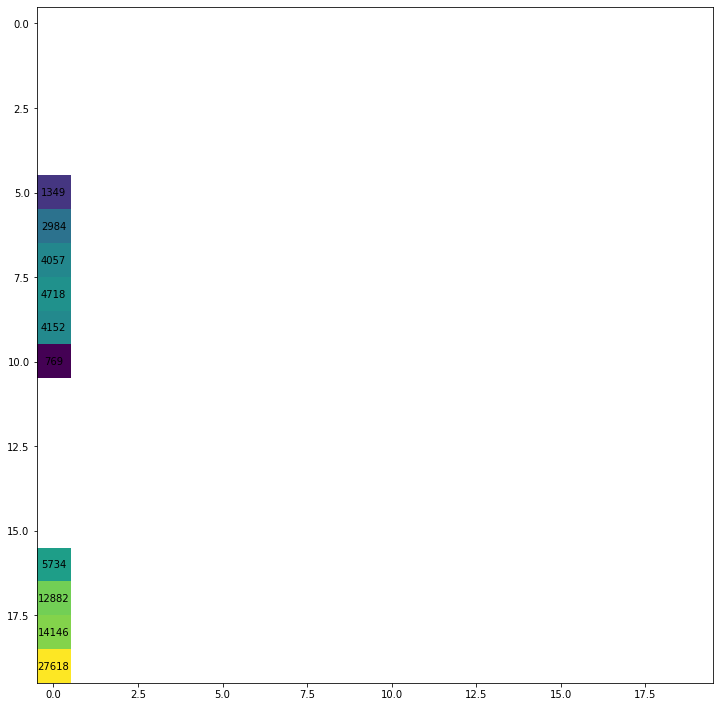

In [ ]:
#test = np.vstack([data_cs['sersicfit'][:,1], data_cs['mag_auto']]).T
#Hitmap(som, test, figsize=(10,10))

Hitmap(som, data_cs['sersicfit'][:,1], figsize=(10,10))

In [ ]:
interactive_plot(choice_cs, nb_cs, vars_cs)

interactive(children=(FloatSlider(value=9.0, description='sigma', max=18.0, min=1.0, step=0.5), FloatSlider(va…

<a name="S5"></a>
# TU dataset

In [ ]:
from astropy.io import fits

path_TU = "TU_created.fits"

with fits.open(path_TU) as hdul:
    hdr = hdul[0].header # header
    data_tu = hdul[1].data # data_tu
    cols = hdul[1].columns # cols
    Names_tu = cols.names # cols names

## Infos

In [ ]:
hdul.info()
Names_tu

Filename: TU_created.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   314709R x 6C   [D, D, D, D, D, D]   


['mag', 'half_light_radius', 'q', 'SSersic_n', 'PA', 'bt']

In [ ]:
info_min_max(data_tu, Names_tu)

mag 

Max 62.548
Min 15.5034

-------------------------------

half_light_radius 

Max 37.939921001861435
Min 0.001351005439189643

-------------------------------

q 

Max 1.0
Min 0.101

-------------------------------

SSersic_n 

Max 5.762576457449746
Min 0.24720666300706678

-------------------------------

PA 

Max 90.0
Min -90.0

-------------------------------

bt 

Max 1.0
Min 0.0

-------------------------------



## Cuts and normalizations

### Half light radius (cut only)

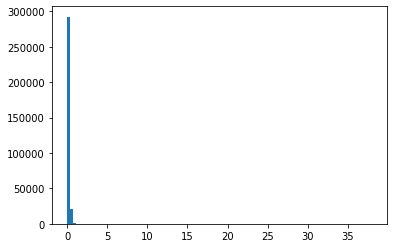

In [ ]:
plt.hist(data_tu['half_light_radius'], bins=100);

nombre d'elements suppr : 338


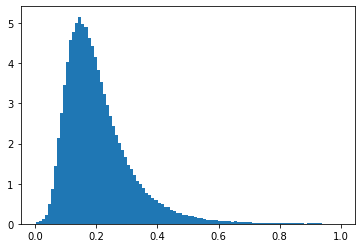

In [ ]:
hlr_sup1 = np.argwhere(data_tu['half_light_radius']>1) # suppression des elements de hlr > 1
print("nombre d'elements suppr :",len(hlr_sup1)) # nombre d'elements supprimes

data_tu = np.delete(data_tu, hlr_sup1)

plt.hist(data_tu['half_light_radius'], bins=100, density=True);

### Magnitude (cut and normalize)

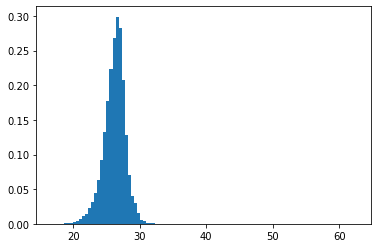

In [ ]:
plt.hist(data_tu['mag'], bins=100, density=True);

nombre d'elements suppr : 22


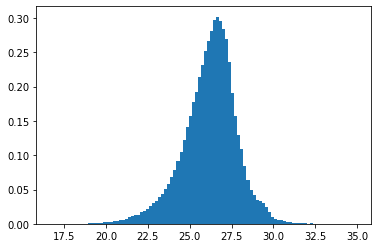

In [ ]:
mag_sup = np.argwhere(data_tu['mag']>35) # suppression des elements de mag > 40
print("nombre d'elements suppr :",len(mag_sup)) # nombre d'elements supprimes

data_tu = np.delete(data_tu, mag_sup)

plt.hist(data_tu['mag'], bins=100, density=True);

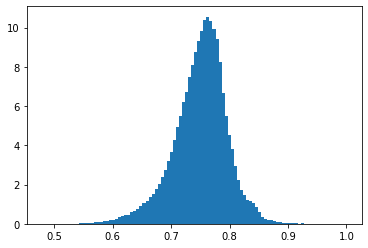

In [ ]:
data_tu['mag'] /= max(data_tu['mag'])# normalisation de mag pour le som

plt.hist(data_tu['mag'], bins=100, density=True);

### Sersic (normalize only)

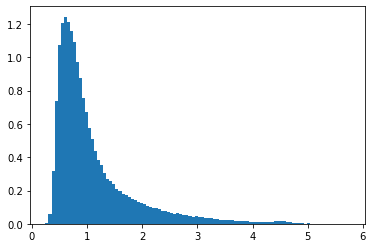

In [ ]:
plt.hist(data_tu['SSersic_n'], bins=100, density=True);

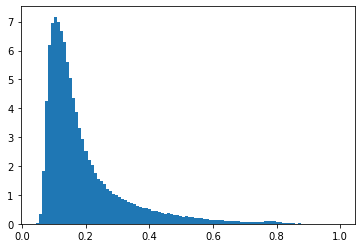

In [ ]:
data_tu['SSersic_n'] /= max(data_tu['SSersic_n'])

plt.hist(data_tu['SSersic_n'], bins=100, density=True);

## Selecting variables

In [ ]:
variables = Names_tu.copy()

caption = Label(value='Select some variables (at least 2)')
boxs = [Checkbox(description=i) for i in variables]

display(caption, *boxs)

Label(value='Select some variables (at least 2)')

Checkbox(value=False, description='mag')

Checkbox(value=False, description='half_light_radius')

Checkbox(value=False, description='q')

Checkbox(value=False, description='SSersic_n')

Checkbox(value=False, description='PA')

Checkbox(value=False, description='bt')

In [ ]:
dataset_i = []
vars_tu = []
cols = 0
for i in range(len(boxs)):
    if boxs[i].value==1:
        dataset_i.append(data_tu[Names_tu[i]])
        vars_tu.append(variables[i])
        cols += 1

assert cols>1, "pick at least 2 variables"

choice_tu = np.vstack([*dataset_i]).T

nb_tu = data_tu.shape[0] # rows number 
print("Nombre d'éléments :", nb_tu)
print("Selected variables :",vars_tu)

Nombre d'éléments : 314349
Selected variables : ['mag', 'half_light_radius', 'q', 'SSersic_n']


## SOMs training and visualisation

In [ ]:
interactive_plot(choice_tu, nb_tu, vars_tu)

interactive(children=(FloatSlider(value=13.0, description='sigma', max=25.0, min=1.0, step=0.5), FloatSlider(v…